### 🧠 ¿Qué es la Planificación y Descomposición de Consultas?
La Planificación y Descomposición de Consultas es una técnica donde una consulta compleja del usuario se divide en sub-preguntas o tareas más simples, permitiendo que un sistema (como un agente RAG):

- Entienda la pregunta más profundamente
- Recupere información más precisa y completa
- Ejecute razonamiento paso a paso

Es como hacer ingeniería inversa de una pregunta en pasos manejables antes de responderla.

🧠 ¿Qué hay de nuevo en esta versión?
- ✅ Agregar un Nodo Planificador de Consultas
- ✅ Dividir consultas complejas del usuario en sub-preguntas
- ✅ Recuperar documentos por cada sub-pregunta
- ✅ Combinar todos los contextos recuperados
- ✅ Generar una respuesta final consolidada

In [1]:
# Importación del módulo os para interactuar con el sistema operativo (variables de entorno, rutas, etc.)
import os

# Importación de List desde typing para definir tipos de datos (listas tipadas)
from typing import List

# Importación de BaseModel desde pydantic para crear modelos de datos con validación automática
from pydantic import BaseModel

# Importación de OpenAIEmbeddings para generar embeddings (representaciones vectoriales) usando la API de OpenAI
from langchain_openai import OpenAIEmbeddings

# Importación de Document, la clase base de LangChain para representar documentos con contenido y metadatos
from langchain.schema import Document

# Importación de RecursiveCharacterTextSplitter para dividir textos largos en chunks (fragmentos) de manera recursiva
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Importación de FAISS, una biblioteca de Facebook para búsqueda eficiente de similitud en vectores
from langchain.vectorstores import FAISS

# Importación de TextLoader para cargar archivos de texto plano (.txt)
# Importación de WebBaseLoader para cargar contenido directamente desde URLs web
from langchain_community.document_loaders import TextLoader, WebBaseLoader

# Importación de StateGraph para crear grafos de estado (flujos de trabajo con nodos y aristas)
# END es un marcador especial que indica el final del grafo
from langgraph.graph import StateGraph, END

c:\Udemy\RAGBootcamp\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
# Importación del módulo os para acceder a variables de entorno
import os

# Importación de init_chat_model para inicializar modelos de chat de diferentes proveedores
from langchain.chat_models import init_chat_model

# Importación de load_dotenv para cargar variables de entorno desde un archivo .env
from dotenv import load_dotenv

# Configuración de la variable de entorno OPENAI_API_KEY con el valor obtenido del archivo .env
# Esto permite autenticarse con la API de OpenAI
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

# Inicialización del modelo de lenguaje usando GPT-4o (optimizado) de OpenAI
# Este será el LLM principal para planificar consultas y generar respuestas
llm=init_chat_model("openai:gpt-4o")

In [3]:
# ----------------------------
# 1. Cargar e Incrustar Documentos
# ----------------------------

# Lista de URLs de donde se cargarán los documentos
# Primera URL: artículo sobre agentes de IA
# Segunda URL: artículo sobre generación de video por difusión
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/"
]

# Inicialización de una lista vacía para almacenar todos los documentos cargados
docs = []

# Iteración sobre cada URL en la lista de URLs
for url in urls:
    # WebBaseLoader(url).load() carga el contenido HTML de la URL y lo convierte en documentos
    # .extend() agrega todos los documentos cargados de esta URL a la lista docs
    docs.extend(WebBaseLoader(url).load())

# Creación de un splitter (divisor) para fragmentar los documentos largos
# chunk_size=500: cada fragmento tendrá aproximadamente 500 caracteres
# chunk_overlap=50: habrá una superposición de 50 caracteres entre fragmentos consecutivos
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)

# División de todos los documentos en chunks (fragmentos) más pequeños
# Esto facilita la recuperación de información relevante y específica
chunks = splitter.split_documents(docs)

# Inicialización del modelo de embeddings de OpenAI
# Este modelo convierte texto en vectores numéricos para búsqueda semántica
embedding = OpenAIEmbeddings()

# Creación de un vector store (base de datos vectorial) usando FAISS
# .from_documents() toma los chunks y genera embeddings para cada uno
# FAISS indexa estos vectores para búsquedas rápidas de similitud
vectorstore = FAISS.from_documents(chunks, embedding)

# Conversión del vector store en un retriever (recuperador)
# El retriever es la interfaz estándar para buscar documentos relevantes
retriever = vectorstore.as_retriever()


In [4]:
# ----------------------------
# 2. Esquema del Estado
# ----------------------------

# Clase que define el estado del flujo de trabajo RAG con planificación de consultas
# Hereda de BaseModel (Pydantic) para validación automática de tipos y datos
class RAGState(BaseModel):
    # question: la pregunta original del usuario (tipo string, campo obligatorio)
    question: str
    
    # sub_questions: lista de sub-preguntas generadas a partir de la pregunta principal
    # Por defecto es una lista vacía []
    # Estas sub-preguntas permiten descomponer consultas complejas en partes más simples
    sub_questions: List[str] = []
    
    # retrieved_docs: lista de todos los documentos recuperados (de todas las sub-preguntas)
    # Por defecto es una lista vacía []
    retrieved_docs: List[Document] = []
    
    # answer: la respuesta final consolidada generada por el LLM
    # Por defecto es una cadena vacía ""
    answer: str = ""

In [5]:
# ----------------------------
# 3. Nodos (Funciones del Grafo)
# ----------------------------

## a. Planificador de Consultas: divide la pregunta de entrada en sub-preguntas
def plan_query(state: RAGState) -> RAGState:
    """
    Esta función toma una pregunta compleja y la descompone en 2-3 sub-preguntas más simples.
    Esto permite una recuperación de información más precisa y un razonamiento más estructurado.
    """
    
    # Construcción del prompt para el LLM solicitando la descomposición de la pregunta
    # Se le pide explícitamente que genere 2-3 sub-preguntas
    prompt = f"""
Divide la siguiente pregunta compleja en 2-3 sub-preguntas:

Pregunta: {state.question}

Sub-preguntas:
"""
    # Invocación del LLM con el prompt para obtener las sub-preguntas
    result = llm.invoke(prompt)
    
    # Procesamiento de la respuesta del LLM:
    # 1. .strip() elimina espacios en blanco al inicio y final
    # 2. .split("\n") divide el texto en líneas
    # 3. line.strip("- ").strip() elimina guiones y espacios de cada línea
    # 4. if line.strip() filtra líneas vacías
    # El resultado es una lista limpia de sub-preguntas
    sub_questions = [line.strip("- ").strip() for line in result.content.strip().split("\n") if line.strip()]
    
    # Retorna un nuevo estado con la pregunta original y las sub-preguntas generadas
    return RAGState(question=state.question, sub_questions=sub_questions)

## b. Recuperar documentos para cada sub-pregunta
def retrieve_for_each(state: RAGState) -> RAGState:
    """
    Esta función recupera documentos relevantes para cada sub-pregunta individualmente.
    Luego combina todos los documentos en una sola lista para proporcionar contexto completo.
    """
    
    # Inicialización de una lista vacía para almacenar todos los documentos recuperados
    all_docs = []
    
    # Iteración sobre cada sub-pregunta generada en el paso anterior
    for sub in state.sub_questions:
        # Invocación del retriever con la sub-pregunta actual
        # Esto busca documentos similares semánticamente a esta sub-pregunta específica
        docs = retriever.invoke(sub)
        
        # Agregación de los documentos recuperados a la lista completa
        # .extend() agrega todos los elementos de docs a all_docs
        all_docs.extend(docs)
    
    # Retorna un nuevo estado con:
    # - question: la pregunta original
    # - sub_questions: las sub-preguntas
    # - retrieved_docs: todos los documentos recuperados de todas las sub-preguntas
    return RAGState(question=state.question, sub_questions=state.sub_questions, retrieved_docs=all_docs)

## c. Generar respuesta final
def generate_final_answer(state: RAGState) -> RAGState:
    """
    Esta función genera la respuesta final consolidada usando todos los documentos recuperados.
    Combina la información de todas las sub-preguntas para responder la pregunta original.
    """
    
    # Concatenación del contenido de todos los documentos recuperados
    # Se unen con dos saltos de línea (\n\n) para separar claramente cada fragmento
    # Esto crea un contexto unificado y completo para el LLM
    context = "\n\n".join([doc.page_content for doc in state.retrieved_docs])
    
    # Construcción del prompt final para generar la respuesta
    # Incluye todo el contexto recuperado y la pregunta original del usuario
    prompt = f"""
Usa el contexto a continuación para responder la pregunta.

Contexto:
{context}

Pregunta: {state.question}
"""
    
    # Invocación del LLM con el prompt completo para generar la respuesta final
    # .content extrae el texto de la respuesta del LLM
    answer = llm.invoke(prompt).content
    
    # Retorna un nuevo estado con todos los campos actualizados, incluyendo la respuesta final
    return RAGState(question=state.question, sub_questions=state.sub_questions, retrieved_docs=state.retrieved_docs, answer=answer)


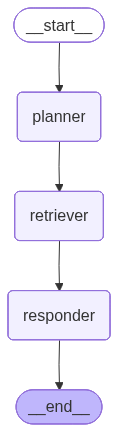

In [6]:
# ----------------------------
# 4. Construir LangGraph
# ----------------------------

# Creación del constructor del grafo de estado usando la clase RAGState
# Este grafo define el flujo de trabajo completo del sistema RAG con planificación de consultas
builder = StateGraph(RAGState)

# Agregado de nodos al grafo
# Cada nodo es una función que procesa y transforma el estado

# Nodo "planner": descompone la pregunta principal en sub-preguntas
# Este es el primer paso para entender mejor la consulta compleja
builder.add_node("planner", plan_query)

# Nodo "retriever": recupera documentos relevantes para cada sub-pregunta
# Esto asegura que se obtenga información completa para todos los aspectos de la pregunta
builder.add_node("retriever", retrieve_for_each)

# Nodo "responder": genera la respuesta final consolidada usando todos los documentos
# Combina la información de todas las sub-preguntas en una respuesta coherente
builder.add_node("responder", generate_final_answer)

# Establecer el punto de entrada del grafo (primer nodo a ejecutar)
# El flujo comienza con el planificador que descompone la pregunta
builder.set_entry_point("planner")

# Definición de aristas (edges) - conexiones secuenciales entre nodos

# Después del "planner", siempre ir al "retriever"
# Una vez descompuesta la pregunta, se procede a recuperar documentos
builder.add_edge("planner", "retriever")

# Después del "retriever", siempre ir al "responder"
# Una vez recuperados todos los documentos, se genera la respuesta final
builder.add_edge("retriever", "responder")

# Después del "responder", ir a END (marcador especial que termina el grafo)
# Una vez generada la respuesta, el flujo termina
builder.add_edge("responder", END)

# Compilación del grafo para hacerlo ejecutable
# .compile() valida la estructura y crea el grafo final optimizado
graph = builder.compile()

# Mostrar el grafo compilado (en Jupyter esto puede renderizar una visualización)
graph

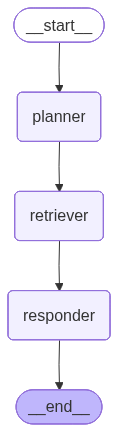

In [7]:
# Mostrar el grafo de nuevo (útil para visualización en notebooks)
graph

In [8]:
# ----------------------------
# 5. Ejecutar el pipeline
# ----------------------------

# Verifica si este script se está ejecutando como programa principal (no importado como módulo)
if __name__ == "__main__":
    
    # Definición de una consulta compleja del usuario que combina dos temas diferentes:
    # 1. Cómo funcionan los bucles de agentes (agent loops)
    # 2. Cuáles son los desafíos en la generación de video por difusión
    # Esta consulta compleja es ideal para demostrar la descomposición en sub-preguntas
    user_query = "Explica cómo funcionan los bucles de agentes y cuáles son los desafíos en la generación de video por difusión?"
    
    # Creación del estado inicial con solo la pregunta del usuario
    # Los demás campos (sub_questions, retrieved_docs, answer) usarán sus valores por defecto
    initial_state = RAGState(question=user_query)
    
    # Invocación del grafo con el estado inicial
    # .invoke() ejecuta todo el flujo de trabajo:
    # 1. Planifica y descompone la pregunta
    # 2. Recupera documentos para cada sub-pregunta
    # 3. Genera la respuesta final consolidada
    final_state = graph.invoke(initial_state)
    
    # Impresión del estado final completo (útil para depuración)
    # Muestra todos los campos: question, sub_questions, retrieved_docs, answer
    print(final_state)

    # Impresión de las sub-preguntas generadas por el planificador
    print("\n🔍 Sub-preguntas:")
    # Iteración sobre cada sub-pregunta y su impresión con un guion como viñeta
    for q in final_state['sub_questions']:
        print("-", q)

    # Impresión de la respuesta final consolidada
    # Esta respuesta combina información de todas las sub-preguntas
    print("\n✅ Respuesta Final:\n", final_state['answer'])

{'question': 'Explica cómo funcionan los bucles de agentes y cuáles son los desafíos en la generación de video por difusión?', 'sub_questions': ['1. ¿Cómo operan los bucles de agentes y cuál es su papel en los sistemas de inteligencia artificial?', '2. ¿Cuáles son los principios fundamentales detrás de la generación de video mediante métodos de difusión?', '3. ¿Qué desafíos enfrentan actualmente los modelos de difusión en la generación de video, y cómo afectan estos desafíos a la calidad y eficiencia del proceso?'], 'retrieved_docs': [Document(id='12975161-2201-4c29-a710-f2791ecf566b', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copie